# Do Batch Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


## BNB Sample Histograms - Nue Nue

In [2]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy', "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z", "nu_e"]


# These are examples of variables present in MC samples only
nue_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['topological_score', 'CosmicIPAll3D', 'shr_tkfit_dedx_V', 'shrsubclusters2', 'nslice', 'sub', 'shr_tkfit_dedx_U', 'shr_energy_tot_cali', 'nproton', 'shr_energy', 'hits_ratio', 'flash_time', 'n_showers', 'shrsubclusters1', 'trkshrhitdist2', 'shrmoliereavg', 'slnhits', 'trk_energy_tot', 'shr_tkfit_nhits_V', 'shr_tkfit_npoints', 'nu_pdg', 'n_tracks', 'true_nu_vtx_z', 'ccnc', 'trk_score_v', 'run', 'slnunhits', 'tksh_angle', 'category', 'true_nu_vtx_y', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_z', 'shr_energy_cali', 'n_tracks_contained', 'evt', 'reco_nu_vtx_sce_y', 'n_showers_contained', 'shr_distance', 'selected', 'contained_fraction', 'tksh_distance', 'shr_tkfit_nhits_U', 'true_nu_vtx_x', 'shr_score', 'shrsubclusters0', 'trk_energy', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_Y', 'nu_e']


In [3]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [4]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [5]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [6]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  9.263726949691772


In [7]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [8]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [9]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [10]:
# add back the cosmic category, for background only
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [11]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [12]:
#Define signal catagories

nue_nue["is_signal"] = nue_nue["category"] == 11

In [13]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [14]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [15]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [16]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [17]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(67348, 113)


In [18]:
datasets_bdt = nue_nue

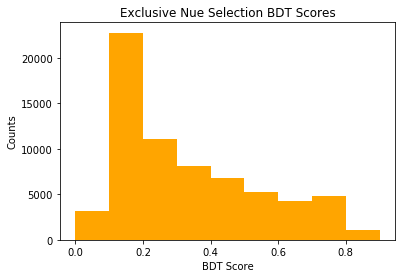

In [19]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [20]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

In [21]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  67348

6.7348
6
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[0.0, 0.0, 0.0, 0.024009898610307445, 0.0, 0.04110990977924445]

SUMS
[0.004432086686190869, 0.010957549004236414, 0.16598438376367666, 0.9730459091888221, 16.504858200935395, 16.504858200935395, 55.89114800025766]
[0.006525462318045545, 0.15502683475944024, 0.8070615254251454, 15.531812291746572, 0.0, 39.38628979932226]

Wanted List:
[8.966174210331095, 18.462360921371022, 7.629225265191619, 2.5241172910701266, 1.0200419264673641, 0.48534303933904255, 0.16176268790551518, 0.06423227313003821, 0.04110990977924445, 0.0319222747371839]

True
Full numbers =  [ 315. 2141. 2054.  924.  485.  247. 

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[0.0, 0.0, 0.0, 0.02119951447293822, 0.0, 0.024215714798501153]

SUMS
[0.013341096240290732, 0.030548744017852566, 0.2050580017924693, 1.1096813368550642, 16.804863650619716, 16.804863650619716, 57.1039442563895]
[0.017207647777561834, 0.17450925777461673, 0.904623335062595, 15.69518231376465, 0.0, 40.29908060576978]

Wanted List:
[10.198383289803154, 17.607062916206477, 7.736167006019453, 2.6897821847808885, 1.086763893611973, 0.5049835034598261, 0.2494575039720246, 0.18311652216645768, 0.024215714798501153, 0.019148070951025886]

True
Full numbers =  [ 354. 2135. 1959. 1042.  507.  266.  153.   87.   61.   31.]
S

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprec


current_ratio_nums:
[10.198383289803154, 17.607062916206477, 7.736167006019453, 2.692366029338795, 1.086763893611973, 0.5049835034598261, 0.2494575039720246, 0.18311652216645768, 0.024215714798501153, 0.019786339982726747]


current n_tot  [1.23822740e+01 2.39773193e+01 1.20748008e+01 4.72484240e+00
 2.03473519e+00 1.09280673e+00 4.74672654e-01 2.73203892e-01
 4.54152293e-02 2.38740503e-02]

Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[0.0, 0.07359577893944191, 0.0, 0.044878341883404005]

SUMS
[0.0861520475260977, 1.035177873689582, 17.029845379541293, 17.029845379541293, 58.30908619051118]
[0.9490258261634843, 15.99466750585171, 0.0, 41.27924081096989]

Wa

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Selected numbers =  [ 330. 2208. 1953.  948.  515.  290.  165.   76.   50.   33.]
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  1.0  with error =  0.0
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  1.0  with error =  0.0
In bin 4 , eff =  1.0  with error =  0.0
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  1.0  with error =  0.0
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  0.9428571428571428  with error =  0.03923466070431973

current_ratio_nums:
[10.23777244788349, 18.797210405694205, 7.495033403963739, 2.654533890288228, 1.1124349965216995, 0.43466683788946625, 0.25971736932339695, 0.13585968885853816, 0.07213635706439447, 0.008280212141520011]


current n_tot  [1.22845289e+01 2.51716997e+01 1.15023620e+01 4.68352181e+00
 2.20767587e+00 1.04843347e+00 5.49632967e-01 1.93087756e-01
 1.35487191e-01 2.00101973e-02]

Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Selected numbers =  [ 336. 2168. 1974.  952.  513.  247.  136.   77.   58.   21.]
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  0.9995389580451821  with error =  0.00046093566272314523
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  1.0  with error =  0.0
In bin 4 , eff =  1.0  with error =  0.0
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  1.0  with error =  0.0
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  1.0  with error =  0.0

current_ratio_nums:
[10.005868244855883, 17.95410058784495, 7.345879936896439, 2.367749287466701, 1.137780302559072, 0.4929934057572183, 0.17642007548005267, 0.16376133636482137, 0.05629401297230885, 0.02418812060318487]


current n_tot  [12.14901252 24.14809215 11.37772537  4.60410179  2.2529581   0.83979529
  0.44695955  0.2560485   0.08270744  0.03243029]

Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprec

True
Full numbers =  [ 290. 2143. 1973.  950.  469.  268.  162.   81.   40.   37.]
Selected numbers =  [ 290. 2143. 1973.  949.  469.  268.  162.   81.   40.   36.]
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  1.0  with error =  0.0
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  0.9989473684210526  with error =  0.001052077416456262
In bin 4 , eff =  1.0  with error =  0.0
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  1.0  with error =  0.0
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  0.972972972972973  with error =  0.026659295238706564

current_ratio_nums:
[9.448207754320023, 17.968641723878328, 7.6852307094414165, 2.446120215224448, 1.2064430607505017, 0.544238231007256, 0.2153691734118155, 0.15295428985302095, 0.08564668039382894, 0.008858936286086718]


current n_tot  [11.33535638 23.95455802 11.824921    4.4765603   2.15427572  1.0697312
  0.43188536  0.34097435  0.15029641  0.050569  ]


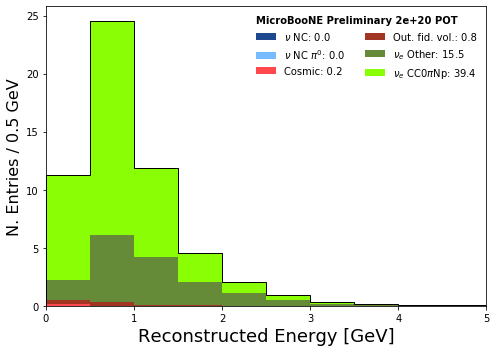

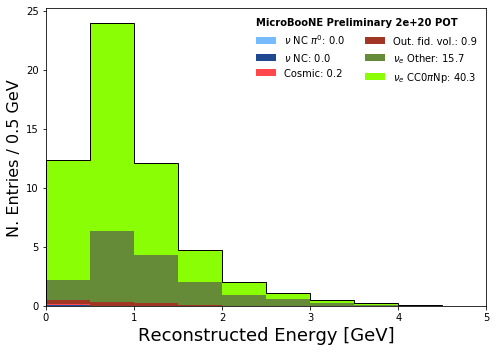

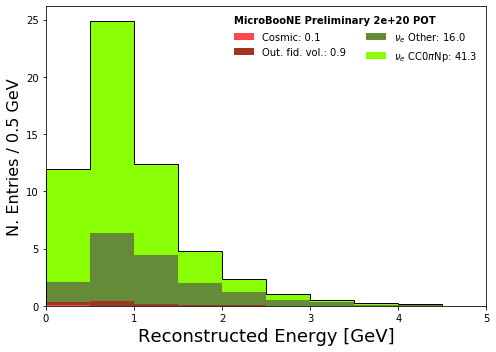

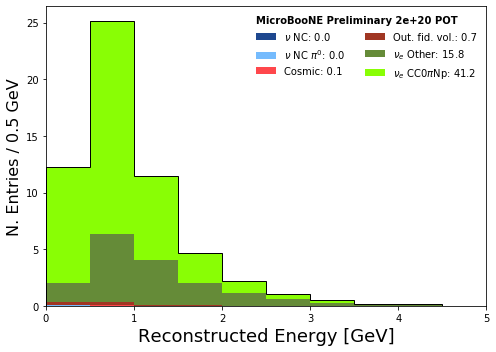

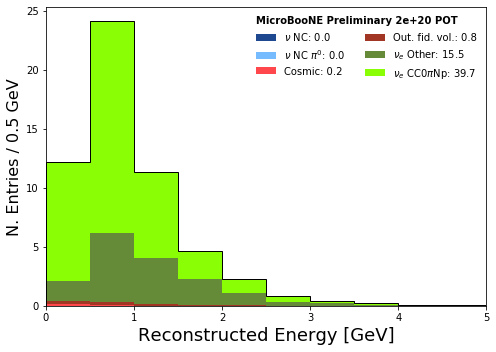

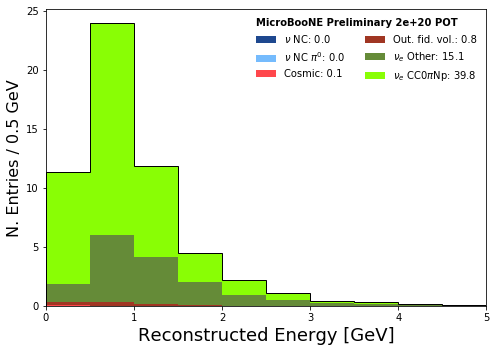

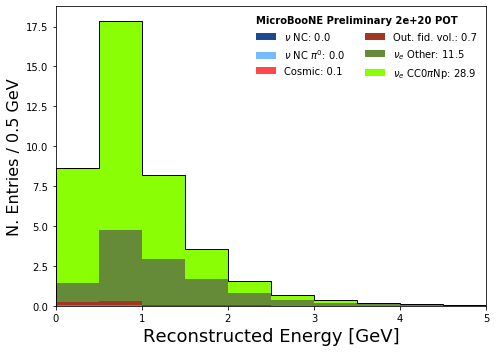

In [22]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


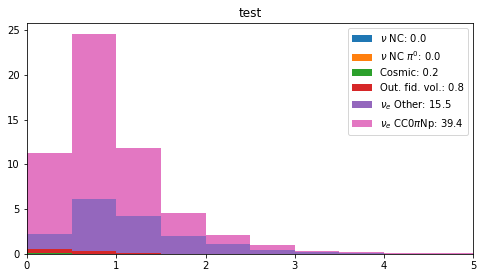

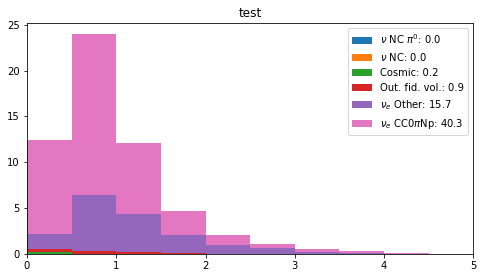

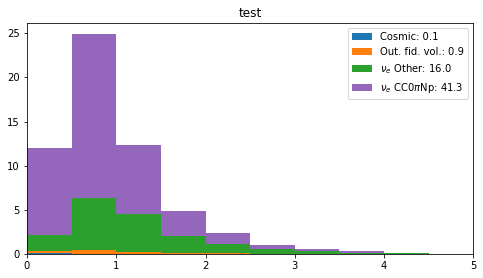

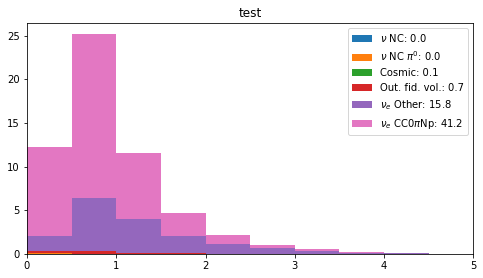

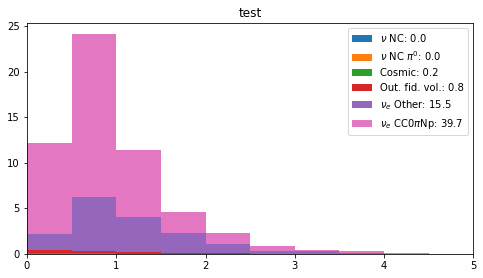

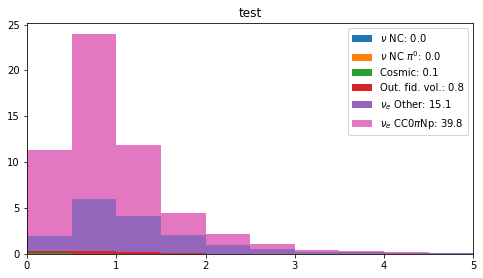

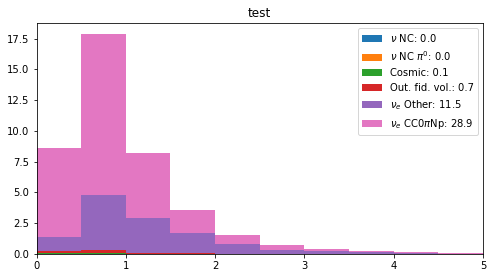

In [23]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [24]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

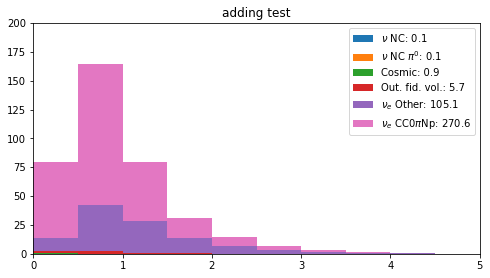

In [25]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 200])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [26]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[0.0, 0.0, 0.0, 0.33261140818791546, 0.0, 0.401709130044992]

SUMS
[0.05927902685497141, 0.14546793714651995, 1.0094312044518976, 6.663576724895168, 111.75253259131607, 111.75253259131607, 382.34256532938025]
[0.08618891029154854, 0.8639632673053776, 5.6541455204432705, 105.0889558664209, 0.0, 270.59003273806417]

Wanted List:
[0.5995328993650686, 0.18374593687008967, 0.04697199970242438, 0.005733099314890966, 0.008448527597861966, 0.008366583177936038, 0.011164221277106146, 0.0, 0.0, 0.0]

[0.5995328993650686, 0.18374593687008967, 0.04697199970242438, 0.005733099314890966, 0.008448527597861966, 0.008366583177936038, 0.011164221277106146, 0.0, 0.0, 0.0]


In [27]:
#varss_tot[0].to_csv('nue_nue_varstot.csv')
#weights_tot[0].to_csv('nue_nue_varstot.csv')

#print(varss_tot[0])


vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

vars_tot_df.to_csv('nue_nue_varstot.csv')
weights_tot_df.to_csv('nue_nue_weightstot.csv')

### Stat Errors

In [28]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  67348

6.7348
6
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_nue

err nue: 
[0.09136083 0.19566208 0.09836138 0.03867985 0.01831459 0.00820267
 0.00282851 0.00148497 0.00049499 0.00028285]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [11.232021   24.566837   11.855573    4.565149    2.0799422   0.9477832
  0.35454524  0.18347363  0.0651198   0.04070034]
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >

In [29]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.6374043994069277, 1.3110844208346846, 0.6559311303415423, 0.26488982473689276, 0.1250200774519024, 0.05642874536573423, 0.026092991278140264, 0.014071829984688112, 0.005657017079271603, 0.002050668691235956]
total selected =  [79.99155616760254, 164.6002426147461, 79.21357250213623, 31.407868146896362, 14.611563444137573, 6.684441387653351, 3.1330971717834473, 1.7203344851732254, 0.7343205027282238, 0.24555005319416523]


In [30]:
np.savetxt("nue_nue_stat_errs.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

### Sys Errors - nue nue

In [31]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_b = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  67348

6.7348
6
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vt

In [32]:
#print(n_tots)
#print(len(n_tots[0]))

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)

#need to add 7 together to make a batch? sum? - over batch, not varation


#cov_nue_nue_ppfx = np.empty([len(final_ns_nue_nue_ppfx[0]), len(final_ns_nue_nue_ppfx[0])])
#cov_nue_nue_ppfx.fill(0)
#Nuniverse = 10

#print(final_ns_nue_nue_ppfx)
#print(final_ns_nue_nue_ppfx[0])

#for n_tot_pair in final_ns_nue_nue_ppfx:
#    for n in n_tot_pair:
#        for i in range(len(final_ns_nue_nue_ppfx[0])):
#            for j in range(len(final_ns_nue_nue_ppfx[0])):
#                cov_nue_nue_ppfx[i][j] += (n[i] - final_ncvs_nue_nue_ppfx[i]) * (n[j] - final_ncvs_nue_nue_ppfx[j])

#cov_nue_nue_ppfx /= Nuniverse


#print("")
#print("cov  = ", cov_nue_nue_ppfx)
#print("")

In [33]:
np.savetxt("nue_nue_syserss_final_ns_ppfx.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

In [34]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_2b = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  67348

6.7348
6
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vt

In [35]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)


In [36]:
np.savetxt("nue_nue_syserss_final_ns_genie.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

In [37]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("weightsReint")
batch_size = 10000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_3b = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  67348
weightsReint
6.7348
6
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 an

In [38]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)

In [39]:
np.savetxt("nue_nue_syserss_final_ns_reint.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

In [40]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
batch_size = 20000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_gb = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  67348
3.3674
4
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 

In [41]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])    
"""
variationNumber=0

#need to add 7 together to make a batch? sum? - over batch, not varation

for n_tot_pair in final_ns_nue_nue_geo:
    tempCov = np.empty([len(final_ns_nue_nue_geo), len(final_ns_nue_nue_geo)])
    tempCov.fill(0)
    for n in n_tot_pair:
        for i in range(len(final_ns_nue_nue_geo)):
            for j in range(len(final_ns_nue_nue_geo)):
                tempCov[i][j] += (n[i] - final_ncvs_nue_nue_geo[i]) * (n[j] - final_ncvs_nue_nue_geo[j])

    tempCov /= 2

    if variationNumber == 0:
        cov_nue_nue_geo = tempCov
        variationNumber = variationNumber+1
    else:
        cov_nue_nue_geo += tempCov
        variationNumber = variationNumber+1

print("")
print("cov NuMI Geo = ", cov_nue_nue_geo)
print("")
"""
"""
#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(n_tots))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots[0])):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_nue_stat_errs = total_errs




variationNumber=0

#need to add 7 together to make a batch? sum? - over batch, not varation

for n_tot in n_tots:
    for n_tot_pair in n_tot:
        tempCov = np.empty([len(n_tots[0][0][0]), len(n_tots[0][0][0])])
        tempCov.fill(0)
        for n in n_tot_pair:
            for i in range(len(n_tots[0][0][0])):
                for j in range(len(n_tots[0][0][0])):
                    tempCov[i][j] += (n[i] - n_cv_tots[0][i]) * (n[j] - n_cv_tots[0][j])

        tempCov /= 2
       
        if variationNumber == 0:
            cov = tempCov
            variationNumber = variationNumber+1
        else:
            cov += tempCov
            variationNumber = variationNumber+1

print("")
print("cov NuMI Geo = ", cov)
print("")
"""

'\n#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...\nmasterlist = []\ntemplist = []\nfor i in range((len(n_tots))):\n    masterlist.append(templist)\n    templist = []\n    for j in range(len(n_tots[0])):\n        templist.append(errs[j][i])\nmasterlist.append(templist)\n    \nmasterlist.pop(0)\n\n\n#deal with adding the errors in each bin\ntotal_errs = []\nholdlist = []\nfor f in masterlist:\n    total_errs.append(sum(holdlist))\n    #print("------------------------------")\n    holdlist = []\n    for g in f:\n        #just add them as they differnt parts of the same total number. This then matches previous when doing total\n        holdlist.append(g)\ntotal_errs.append(sum(holdlist))\n\ntotal_errs.pop(0)\nprint("total errs = ", total_errs)\n\nnue_nue_stat_errs = total_errs\n\n\n\n\nvariationNumber=0\n\n#need to add 7 together to make a batch? sum? - over batch, not varation\n\nfor n_tot in n_tots:\n    for n_tot_pair in n_tot:\n   

In [42]:
np.savetxt("nue_nue_syserss_final_ns_geo.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

## Nue_Mc

In [43]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune

#actually fetch datasets
nue_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy', "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z", "nu_e"]


# These are examples of variables present in MC samples only
nue_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_mc   = nue_mc.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)


['topological_score', 'CosmicIPAll3D', 'shr_tkfit_dedx_V', 'shrsubclusters2', 'nslice', 'sub', 'shr_tkfit_dedx_U', 'shr_energy_tot_cali', 'nproton', 'shr_energy', 'hits_ratio', 'flash_time', 'n_showers', 'shrsubclusters1', 'trkshrhitdist2', 'shrmoliereavg', 'slnhits', 'trk_energy_tot', 'shr_tkfit_nhits_V', 'shr_tkfit_npoints', 'nu_pdg', 'n_tracks', 'true_nu_vtx_z', 'ccnc', 'trk_score_v', 'run', 'slnunhits', 'tksh_angle', 'category', 'true_nu_vtx_y', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_z', 'shr_energy_cali', 'n_tracks_contained', 'evt', 'reco_nu_vtx_sce_y', 'n_showers_contained', 'shr_distance', 'selected', 'contained_fraction', 'tksh_distance', 'shr_tkfit_nhits_U', 'true_nu_vtx_x', 'shr_score', 'shrsubclusters0', 'trk_energy', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_Y', 'nu_e']


In [44]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']



In [45]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [46]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [47]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  4.846994161605835


In [48]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 


In [49]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']


In [50]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_mc]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])



In [51]:
# add back the cosmic category, for background only
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
   

In [52]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [53]:
#Define signal catagories

nue_mc["is_signal"] = nue_mc["category"] == 11

In [54]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)


In [55]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [56]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [57]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [58]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(46815, 113)


In [59]:
datasets_bdt = nue_mc

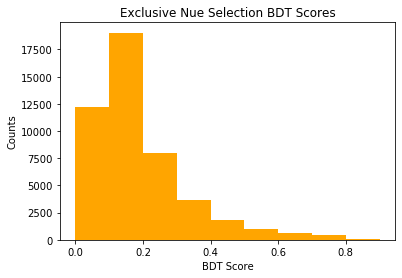

In [60]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [61]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

In [62]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  46815

4.6815
4
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_mc
Had to return early.
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_mc
Had to return early.
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and tr

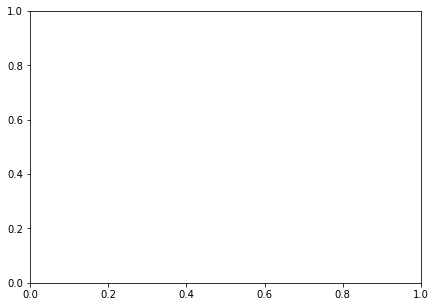

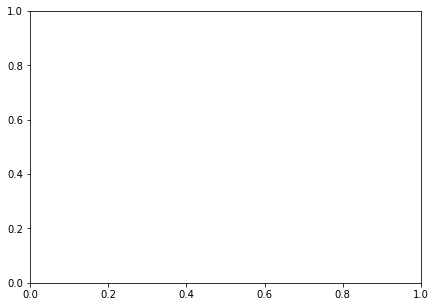

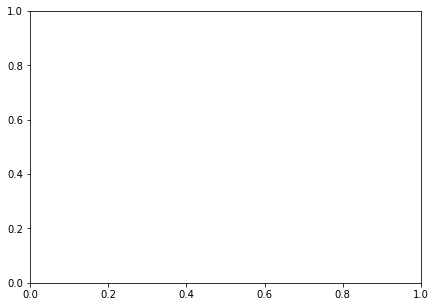

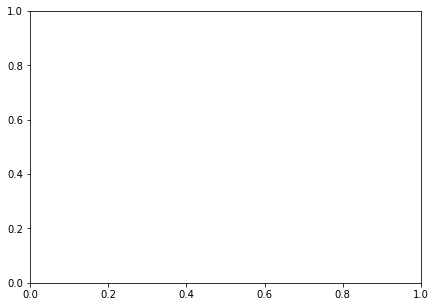

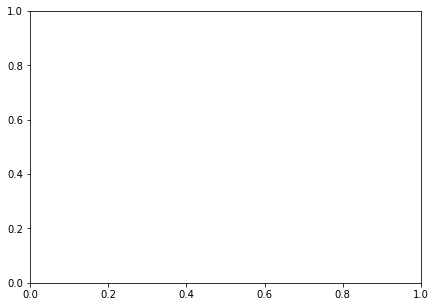

In [63]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "nue_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    mcratio   = pot/2.33652e+21 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


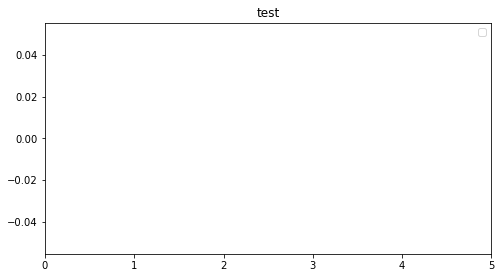

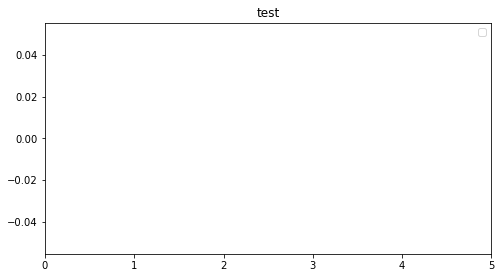

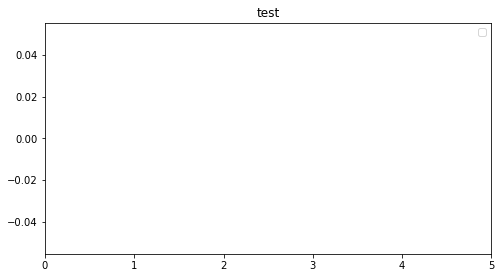

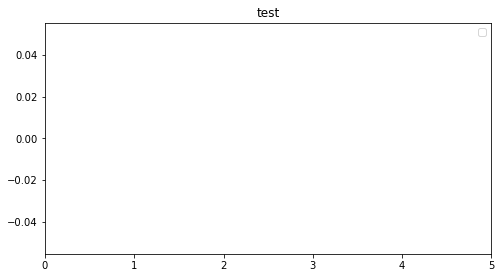

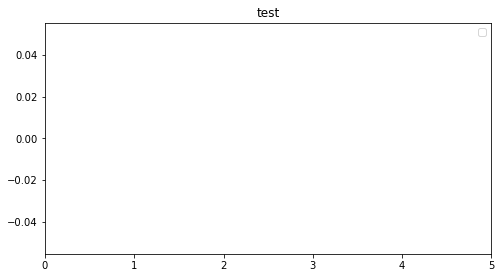

In [64]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()


In [65]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

No handles with labels found to put in legend.


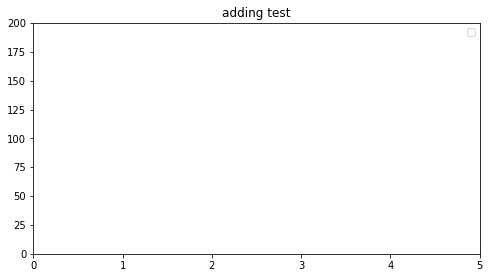

In [66]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 200])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()



In [67]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [68]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

vars_tot_df.to_csv('nue_mc_varstot.csv')
weights_tot_df.to_csv('nue_mc_weightstot.csv')

### Stat Errors

In [69]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 

    
    weights = {
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  46815

4.6815
4
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

err nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

err nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0

In [70]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_mc_stat_errs_selected = total_sels

total errs =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [71]:
np.savetxt("nue_mc_stat_errs.csv", 
           nue_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_stat_errs_selected.csv", 
           nue_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

### sys errs - nue mc

In [72]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21
    
    weights = {
        "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_b = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  46815

4.6815
4
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > 

In [73]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_mc_ppfx = sum(n_cv_tots)

#need to add 7 together to make a batch? sum? - over batch, not varation


cov_nue_mc_ppfx = np.empty([len(final_ns_nue_mc_ppfx[0]), len(final_ns_nue_mc_ppfx[0])])
cov_nue_mc_ppfx.fill(0)
Nuniverse = 10


for n_tot_pair in final_ns_nue_mc_ppfx:
    for n in n_tot_pair:
        for i in range(len(final_ns_nue_mc_ppfx[0])):
            for j in range(len(final_ns_nue_mc_ppfx[0])):
                cov_nue_mc_ppfx[i][j] += (n[i] - final_ncvs_nue_mc_ppfx[i]) * (n[j] - final_ncvs_nue_mc_ppfx[j])

cov_nue_mc_ppfx /= Nuniverse


print("")
print("cov  = ", cov_nue_mc_ppfx)
print("")


cov  =  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]



## Nue_Dirt

In [74]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND

#actually fetch datasets
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_dirt]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy', "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z", "nu_e"]


# These are examples of variables present in MC samples only
nue_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS, flatten=False)

['topological_score', 'CosmicIPAll3D', 'shr_tkfit_dedx_V', 'shrsubclusters2', 'nslice', 'sub', 'shr_tkfit_dedx_U', 'shr_energy_tot_cali', 'nproton', 'shr_energy', 'hits_ratio', 'flash_time', 'n_showers', 'shrsubclusters1', 'trkshrhitdist2', 'shrmoliereavg', 'slnhits', 'trk_energy_tot', 'shr_tkfit_nhits_V', 'shr_tkfit_npoints', 'nu_pdg', 'n_tracks', 'true_nu_vtx_z', 'ccnc', 'trk_score_v', 'run', 'slnunhits', 'tksh_angle', 'category', 'true_nu_vtx_y', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_z', 'shr_energy_cali', 'n_tracks_contained', 'evt', 'reco_nu_vtx_sce_y', 'n_showers_contained', 'shr_distance', 'selected', 'contained_fraction', 'tksh_distance', 'shr_tkfit_nhits_U', 'true_nu_vtx_x', 'shr_score', 'shrsubclusters0', 'trk_energy', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_Y', 'nu_e']


In [75]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [76]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.


In [77]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [78]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  0.4691002368927002


In [79]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [80]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [81]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [82]:
# add back the cosmic category, for background only
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    


In [83]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304



In [84]:
nue_dirt["is_signal"] = nue_dirt["category"] == 11

In [85]:
# Some quick clean up since some strange events get in there
nue_dirt   = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [86]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [87]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [88]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_dirt]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(4634, 95)


In [89]:
datasets_bdt = nue_dirt

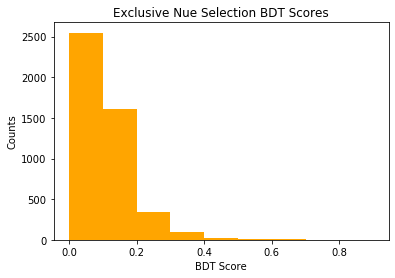

In [90]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [91]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

In [92]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  4634

4.634
4
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  2

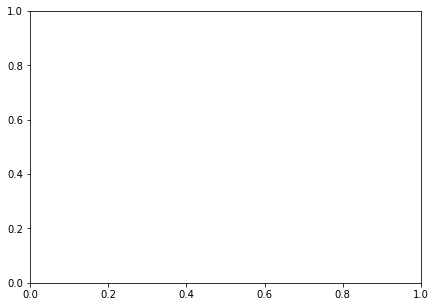

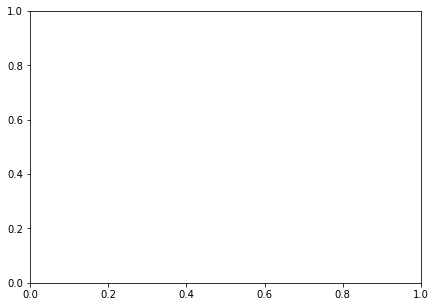

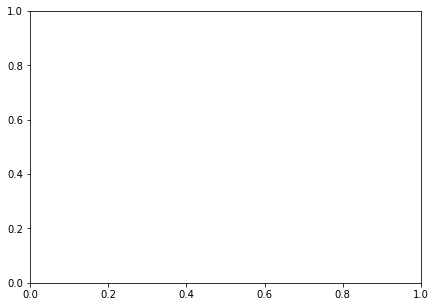

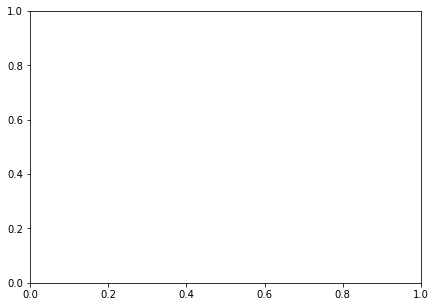

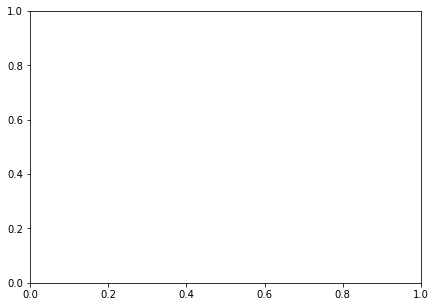

In [93]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 1000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    dirtratio = pot/1.42143e+21
    scalingDRT = 0.35

    # NUE
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


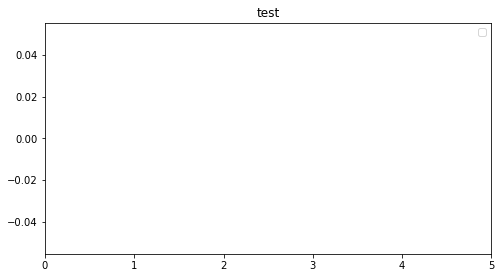

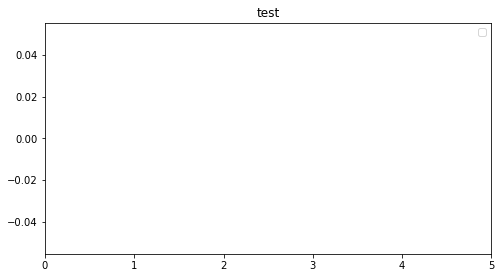

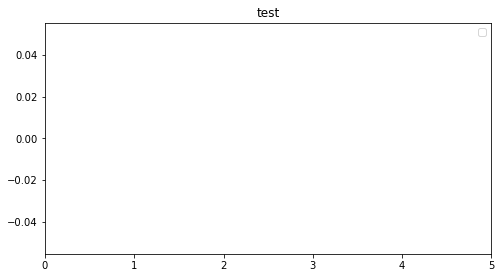

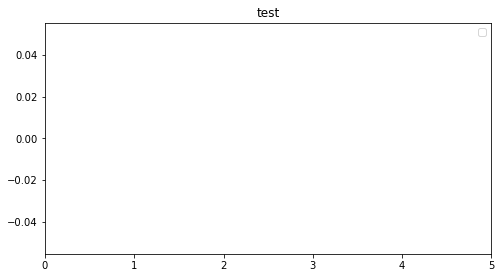

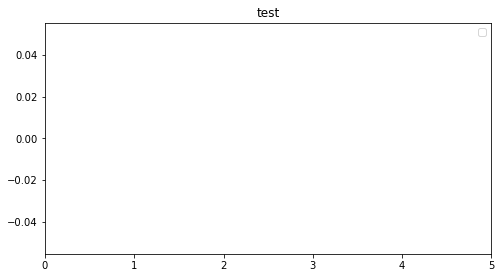

In [94]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [95]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

No handles with labels found to put in legend.


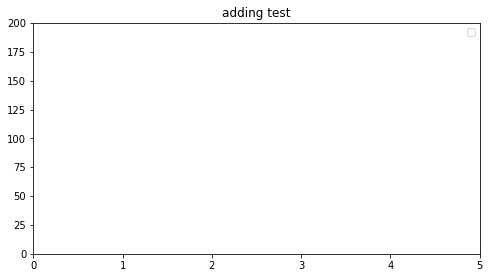

In [96]:
labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 200])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [97]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [98]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

vars_tot_df.to_csv('nue_dirt_varstot.csv')
weights_tot_df.to_csv('nue_dirt_weightstot.csv')

### Stat Errors

In [99]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 1000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    scalingDRTnue = 0.35

    
    weights = {
                "nue_dirt": dirtratio* SPLIT * scalingDRTnue
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  4634

4.634
4
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0. 0. 

In [100]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_dirt_stat_errs = total_errs

#########################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_dirt_stat_errs_selected = total_sels

total errs =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [101]:
np.savetxt("nue_dirt_stat_errs.csv", 
           nue_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_stat_errs_selected.csv", 
           nue_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

### Sys Errs Nue Dirt

Dirt does not get sys errors calculated.

## Now for Numu

## Numu_Mc

In [102]:
tree = "NeutrinoSelectionFilter"

NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND

numu_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]


uproot_v = [numu_mc] 
print(type(numu_mc))


numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        #"nu_e", 
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
        "true_nu_vtx_z", "true_nu_vtx_y", "true_nu_vtx_x", "nu_e"
    ]

numu_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz"]

#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

<class 'uproot.rootio.TTree'>
['muon_e', 'topological_score', 'CosmicIPAll3D', 'trk_llr_pid_score_v', 'interaction', 'nslice', 'CosmicDirAll3D', 'sub', 'isVtxInFiducial', 'nproton', 'reco_nu_vtx_x', 'backtracked_pdg', 'reco_nu_vtx_y', 'slnhits', 'npi0', 'reco_e', 'nu_pdg', 'CosmicIP', 'true_nu_vtx_z', 'mc_pdg', 'ccnc', '_opfilter_pe_beam', '_opfilter_pe_veto', 'flash_pe', 'true_e_visible', 'slclustfrac', 'theta', 'run', 'slnunhits', 'pi0_e', 'category', 'pion_e', 'slpdg', 'true_nu_vtx_y', 'reco_nu_vtx_sce_x', 'npion', 'reco_nu_vtx_sce_z', 'evt', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_z', 'true_nu_vtx_x', 'pi0truth_elec_etot', 'evnunhits', 'nu_e']


In [103]:
import pandas as pandas
print(type(numu_mc))
mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+numu_varMC
print(type(numu_mc))

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 

print(type(numu_mc))

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF
        
print(type(numu_mc))

<class 'uproot.rootio.TTree'>
<class 'uproot.rootio.TTree'>
<class 'uproot.rootio.TTree'>


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'pandas.core.frame.DataFrame'>


In [104]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [105]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']

In [106]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [107]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [108]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [109]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [110]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)


In [111]:
numu_mc["is_signal"]   = numu_mc["category"] == 11

In [112]:
numu_mc   = numu_mc.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [113]:
NUMU_SEL_QUERY = 'nslice == 1'
NUMU_SEL_QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 '
NUMU_SEL_QUERY += ' and n_muons_tot > 0'
NUMU_SEL_QUERY += ' and n_protons_tot > 0 '

In [114]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  46815

4.6815
4
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_mc
[0.0, 0.0, 0.2552221797822085, 0.0]

SUMS
[0.7763381283964005, 1.988275772332074, 8.004008926173261, 94.53159833796339, 230.854830148938]
[1.2119376439356735, 6.015733153841188, 86.52758941179013, 136.32323181097462]

Wanted List:
[47.01236283017971, 52.78902316602695, 25.7755690653289, 7.939101194510158, 1.9276746388684955, 0.7187240933497776, 0.047248734473697596, 0.11352808823696137, 0.0, 0.0]

True
Full numbers =  [ 40. 274. 232. 108.  57.  37.  20.   7.   6.   5.]
Selected numbers =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In bin 0 , eff =  0.0  with error =  0.0
In bin 1 , eff =  0.0  with error

/home/alex/NuMI/PELEE/batch_plotter_alex.py:1281: RuntimeWarning: divide by zero encountered in double_scalars
  num = current_wanted_list_smeared[i]*(1/current_eff[i])
/home/alex/NuMI/PELEE/batch_plotter_alex.py:1281: RuntimeWarning: invalid value encountered in double_scalars
  num = current_wanted_list_smeared[i]*(1/current_eff[i])
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

[0.0, 0.0, 0.1509074494351097, 3.154525529680541e-10]

SUMS
[1.413059646758836, 3.177578780920192, 9.529291570718241, 87.8356151197493, 231.89379677510067]
[1.764519134161356, 6.351712789798049, 78.30632354903106, 144.05818165535135]

Wanted List:
[48.80324921721262, 56.51756669671967, 26.18559066903195, 9.878152766815163, 2.059487514127028, 0.5240748901999837, 0.09005990092953198, 0.0, 3.154525529680541e-10, 0.0]

True
Full numbers =  [ 44. 281. 263. 113.  70.  26.  20.   8.   3.   6.]
Selected numbers =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In bin 0 , eff =  0.0  with error =  0.0
In bin 1 , eff =  0.0  with error =  0.0
In bin 2 , eff =  0.0  with error =  0.0
In bin 3 , eff =  0.0  with error =  0.0
In bin 4 , eff =  0.0  with error =  0.0
In bin 5 , eff =  0.0  with error =  0.0
In bin 6 , eff =  0.0  with error =  0.0
In bin 7 , eff =  0.0  with error =  0.0
In bin 8 , eff =  0.0  with error =  0.0
In bin 9 , eff =  0.0  with error =  0.0

current_ratio_nums:
[inf, inf, inf, inf, inf,

/home/alex/NuMI/PELEE/batch_plotter_alex.py:1281: RuntimeWarning: divide by zero encountered in double_scalars
  num = current_wanted_list_smeared[i]*(1/current_eff[i])
/home/alex/NuMI/PELEE/batch_plotter_alex.py:1281: RuntimeWarning: invalid value encountered in double_scalars
  num = current_wanted_list_smeared[i]*(1/current_eff[i])
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

True
Full numbers =  [ 42. 269. 279. 110.  57.  29.  15.   8.   4.   5.]
Selected numbers =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In bin 0 , eff =  0.0  with error =  0.0
In bin 1 , eff =  0.0  with error =  0.0
In bin 2 , eff =  0.0  with error =  0.0
In bin 3 , eff =  0.0  with error =  0.0
In bin 4 , eff =  0.0  with error =  0.0
In bin 5 , eff =  0.0  with error =  0.0
In bin 6 , eff =  0.0  with error =  0.0
In bin 7 , eff =  0.0  with error =  0.0
In bin 8 , eff =  0.0  with error =  0.0
In bin 9 , eff =  0.0  with error =  0.0

current_ratio_nums:
[inf, inf, inf, inf, inf, inf, inf, inf, nan, nan]


current n_tot  [5.88809353e+01 8.49625972e+01 4.89362717e+01 2.18248282e+01
 5.74828881e+00 1.86592872e+00 9.11470737e-01 8.43223495e-01
 1.91730641e-01 4.22246327e-02]

Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/NuMI/PELEE/batch_plotter_alex.py:1281: RuntimeWarning: divide by zero encountered in double_scalars
  num = current_want

Full numbers =  [ 41. 288. 237. 114.  52.  36.  22.   7.   5.   3.]
Selected numbers =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In bin 0 , eff =  0.0  with error =  0.0
In bin 1 , eff =  0.0  with error =  0.0
In bin 2 , eff =  0.0  with error =  0.0
In bin 3 , eff =  0.0  with error =  0.0
In bin 4 , eff =  0.0  with error =  0.0
In bin 5 , eff =  0.0  with error =  0.0
In bin 6 , eff =  0.0  with error =  0.0
In bin 7 , eff =  0.0  with error =  0.0
In bin 8 , eff =  0.0  with error =  0.0
In bin 9 , eff =  0.0  with error =  0.0

current_ratio_nums:
[inf, inf, inf, inf, inf, inf, inf, nan, nan, nan]


current n_tot  [59.36664261 76.14156284 51.9331405  19.0216462   7.71870487  1.95905231
  0.91073925  0.53184913  0.19203323  0.        ]

Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/NuMI/PELEE/batch_plotter_alex.py:1281: RuntimeWarning: divide by zero encountered in double_scalars
  num = current_want

True
Full numbers =  [ 30. 192. 176.  67.  40.  26.  13.   6.   4.   3.]
Selected numbers =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In bin 0 , eff =  0.0  with error =  0.0
In bin 1 , eff =  0.0  with error =  0.0
In bin 2 , eff =  0.0  with error =  0.0
In bin 3 , eff =  0.0  with error =  0.0
In bin 4 , eff =  0.0  with error =  0.0
In bin 5 , eff =  0.0  with error =  0.0
In bin 6 , eff =  0.0  with error =  0.0
In bin 7 , eff =  0.0  with error =  0.0
In bin 8 , eff =  0.0  with error =  0.0
In bin 9 , eff =  0.0  with error =  0.0

current_ratio_nums:
[inf, inf, inf, inf, inf, inf, inf, nan, nan, inf]


current n_tot  [41.27010403 53.35442438 36.81739936 15.29595829  4.80806635  1.19551008
  1.28549308  0.25681558  0.          0.08684301]

Returning


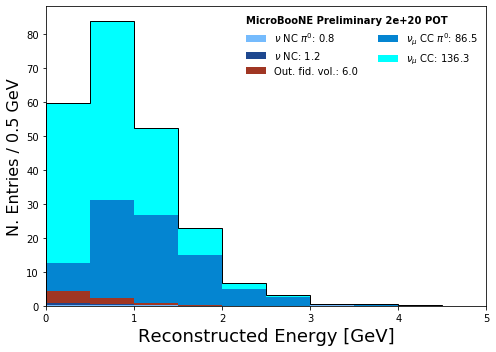

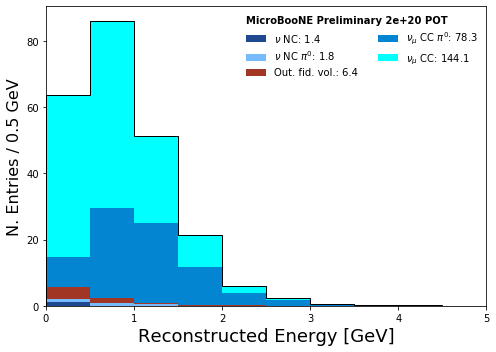

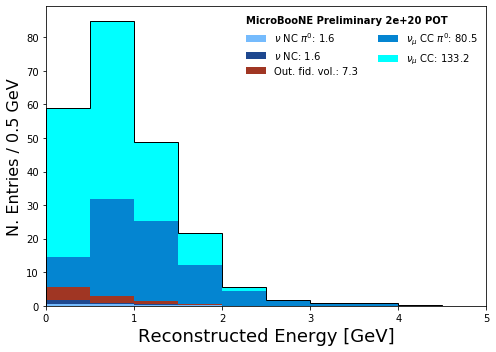

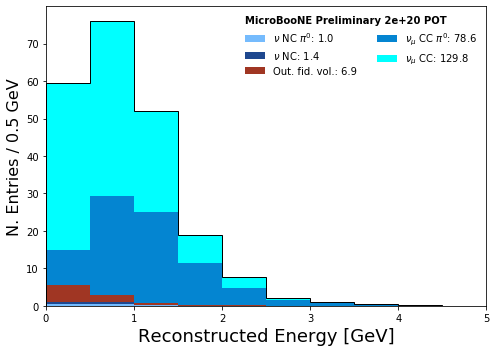

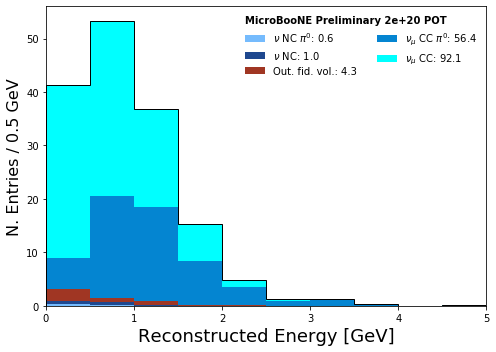

In [115]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    mcratio   = pot/2.33652e+21

    # NUE
    weights = { #full sample mc = 0.38
                "numu_mc": mcratio  * SPLIT * scaling,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


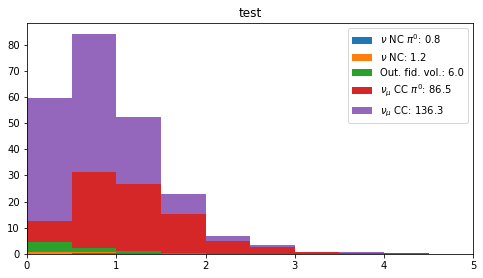

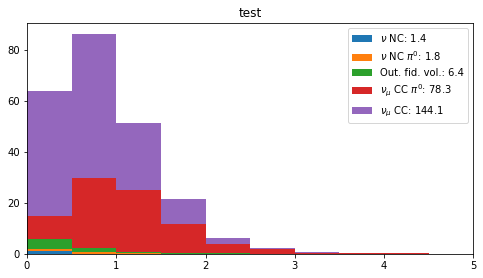

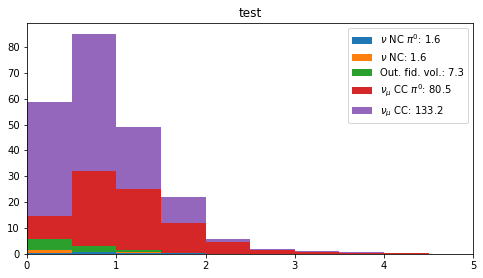

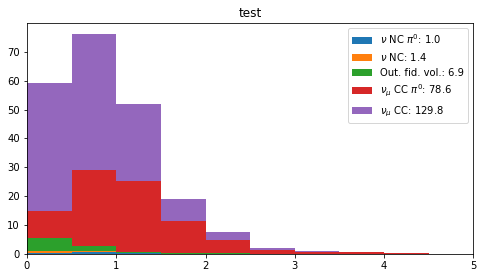

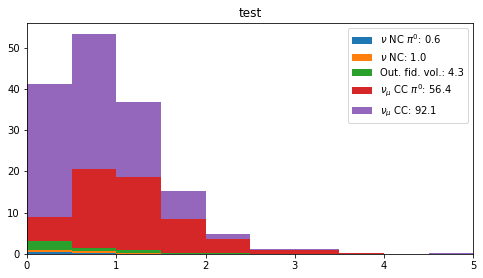

In [116]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [117]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

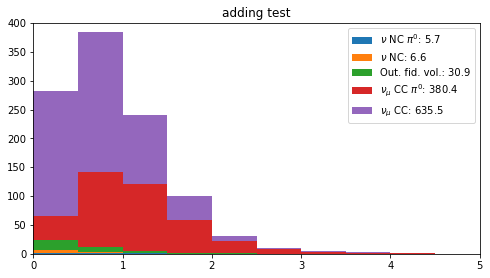

In [118]:
labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 400])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [119]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)
wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)


[0.0, 0.0, 0.7898935014453059, 3.154809746774845e-10]

SUMS
[5.711967039534396, 12.284600700992844, 43.20523353072654, 423.5897846629433, 1059.1021114803043]
[6.572633661458448, 30.920632829733695, 380.38455113221676, 635.512326817361]

Wanted List:
[18.21317369263013, 8.152300740805906, 3.03943904220926, 0.7333834757862157, 0.6335478819951454, 0.05627267543910364, 0.0483602106304879, 0.04415511023744756, 0.0, 0.0]



In [120]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

vars_tot_df.to_csv('numu_mc_varstot.csv')
weights_tot_df.to_csv('numu_mc_weightstot.csv')

### Stat Errors

In [121]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 

    
    weights = {
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  46815

4.6815
4
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

err numu mc: 
[4.96031954 7.42948894 4.73318526 2.07351614 0.65209518 0.28574957
 0.06594221 0.05128839 0.02198074 0.        ]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [59.74718    84.07043    52.41065    23.027185    6.8550134   3.2603009
  0.62490076  0.60394704  0.25522217  0.        ]
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & re

In [122]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errors = ", total_errs)

numu_mc_stat_errs = total_errs

#########################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errors =  [23.402157478279335, 34.37054500019047, 21.76825606385971, 9.070717269289236, 2.8941303080527048, 0.959825494569378, 0.3736725207865517, 0.21980736516855984, 0.07326912172285328, 0.014653824344570656]
total selected =  [282.93465423583984, 384.6849365234375, 241.2638168334961, 100.6843032836914, 31.15453863143921, 10.670203924179077, 4.243940651416779, 2.5467323660850525, 0.7898934781551361, 0.12906763702630997]


In [123]:
np.savetxt("numu_mc_stat_errs.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

## Sys errs - numu mc

In [124]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_b = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  46815

4.6815
4
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x

In [125]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)

In [126]:
np.savetxt("numu_mc_syserss_final_ns_ppfx.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

In [127]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_b = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  46815

4.6815
4
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x

In [128]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

In [129]:
np.savetxt("numu_mc_syserss_final_ns_genie.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

In [130]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_b = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  46815

4.6815
4
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 10
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x

In [131]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

In [132]:
np.savetxt("numu_mc_syserss_final_ns_reint.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

In [133]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = 20000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_gb = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  46815
2.34075
3
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 an

In [134]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))

In [135]:
np.savetxt("numu_mc_syserss_final_ns_geo.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

## Numu_Dirt

In [136]:
tree = "NeutrinoSelectionFilter"

DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND

numu_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]


uproot_v = [numu_dirt] 


numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        #"nu_e", 
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
        "true_nu_vtx_z", "true_nu_vtx_y", "true_nu_vtx_x", "nu_e"
    ]

numu_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz"]

#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['muon_e', 'topological_score', 'CosmicIPAll3D', 'trk_llr_pid_score_v', 'interaction', 'nslice', 'CosmicDirAll3D', 'sub', 'isVtxInFiducial', 'nproton', 'reco_nu_vtx_x', 'backtracked_pdg', 'reco_nu_vtx_y', 'slnhits', 'npi0', 'reco_e', 'nu_pdg', 'CosmicIP', 'true_nu_vtx_z', 'mc_pdg', 'ccnc', '_opfilter_pe_beam', '_opfilter_pe_veto', 'flash_pe', 'true_e_visible', 'slclustfrac', 'theta', 'run', 'slnunhits', 'pi0_e', 'category', 'pion_e', 'slpdg', 'true_nu_vtx_y', 'reco_nu_vtx_sce_x', 'npion', 'reco_nu_vtx_sce_z', 'evt', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_z', 'true_nu_vtx_x', 'pi0truth_elec_etot', 'evnunhits', 'nu_e']


In [137]:
import pandas as pandas

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS


# This needs modifications (add variables from above)
uproot_v = [numu_dirt] 
var_v    = [dirt_var] 

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_dirt =  CVDF

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [138]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [139]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']

In [140]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [141]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [142]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [143]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)


/tmp/ipykernel_5138/3728966960.py:8: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


In [144]:
numu_dirt["is_signal"] = numu_dirt["category"] == 11

In [145]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [146]:
numu_dirt = numu_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
 

In [147]:
NUMU_SEL_QUERY = 'nslice == 1'
NUMU_SEL_QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 '
NUMU_SEL_QUERY += ' and n_muons_tot > 0'
NUMU_SEL_QUERY += ' and n_protons_tot > 0 '

In [148]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  569506

5.69506
5
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_dirt
Had to return early.
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_dirt
Had to return early.
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_

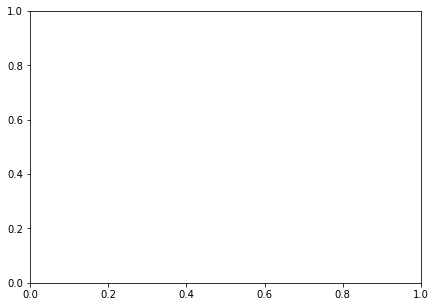

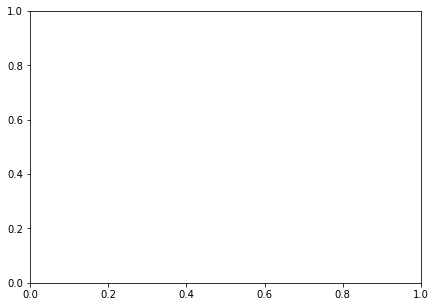

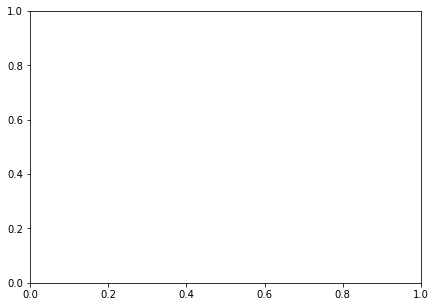

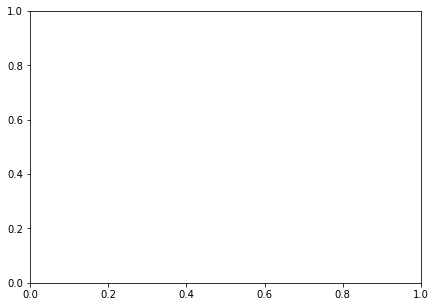

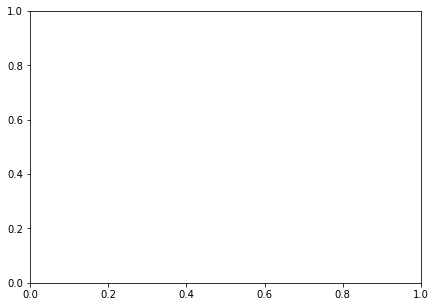

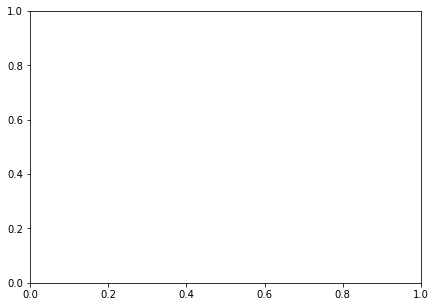

In [149]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 100000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    dirtratio = pot/1.42143e+21
    scalingDRT = 0.60

    # NUE
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


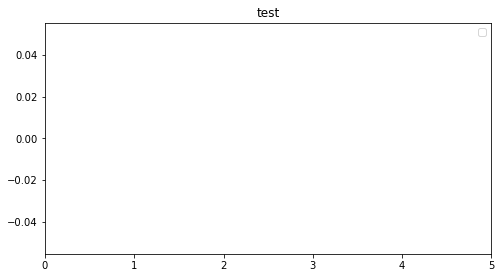

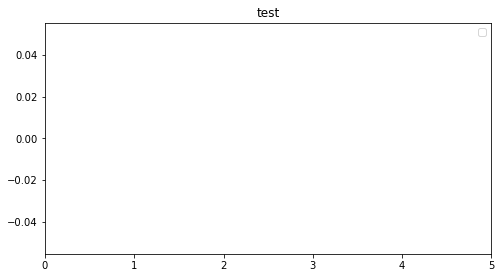

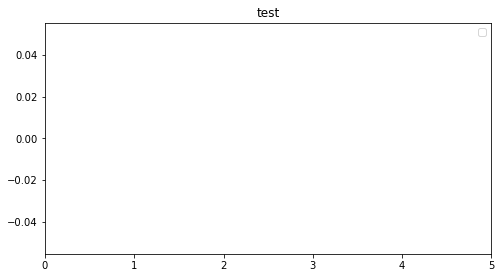

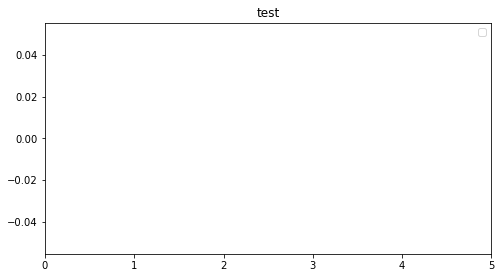

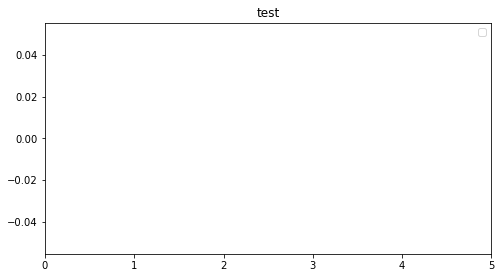

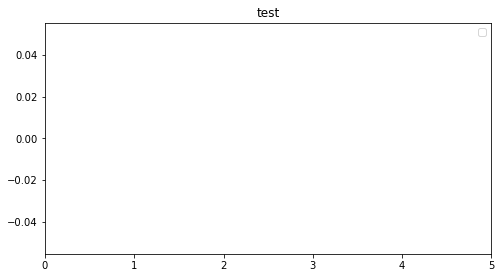

In [150]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()


In [151]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)



No handles with labels found to put in legend.


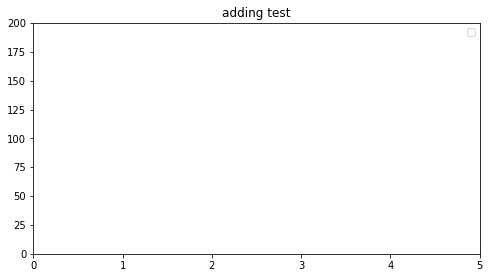

In [152]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 200])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [153]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [154]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

vars_tot_df.to_csv('numu_dirt_varstot.csv')
weights_tot_df.to_csv('numu_dirt_weightstot.csv')

### Stat Errors

In [155]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 100000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    scalingDRTnumu = 0.60

    
    weights = {
                "numu_dirt": dirtratio* SPLIT * scalingDRTnumu
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  569506

5.69506
5
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_dirt

err numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_dirt

err numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys numu dirt: 


In [156]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errors = ", total_errs)

numu_dirt_stat_errs = total_errs


######################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_dirt_stat_errs_selected = total_sels

total errors =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [157]:
np.savetxt("numu_dirt_stat_errs.csv", 
           numu_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_stat_errs_selected.csv", 
           numu_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

## Sys_errs

Dirt does not get sys errors calculated.